In [17]:
# Setup:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import Dataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchmetrics.classification import BinaryAUROC
from xgboost import XGBClassifier
from tqdm import tqdm
import xgboost as xgb

In [ ]:
test_set = pd.read_csv('data/test.csv')
training_set = pd.read_csv('data/train.csv')

In [ ]:
means = None
stdevs = None

# Define preprocessing transform
def conversion_transform(df, is_test = False):
    # drop text columns
    new_df = df.drop(columns=['track_href', 'uri', 'type', 'analysis_url'])

    if is_test == True:
        new_df = new_df.drop(columns=['ID'])

    # Handle dates 
    date_column = new_df["track_album_release_date"].astype(str)

    parsed = pd.to_datetime(date_column, format='%Y-%m-%d', errors='coerce')
    new_df["year"] = parsed.dt.year
    new_df["month"] = parsed.dt.month
    new_df["day"] = parsed.dt.day

    # For year-only dates, extract year and default month/day to 1
    year_only_mask = new_df["year"].isna()
    new_df.loc[year_only_mask, "year"] = pd.to_numeric(date_column[year_only_mask], errors='coerce')
    new_df.loc[year_only_mask, "month"] = 1
    new_df.loc[year_only_mask, "day"] = 1

    new_df = new_df.drop(columns='track_album_release_date')

    if is_test == False:
        # Binarization of the output
        column_names = list(new_df.columns.values)
        column_names.append(column_names.pop(column_names.index('Popularity_Type')))
        new_df = new_df[column_names]

        lb = LabelBinarizer()
        new_df['Popularity_Type'] = lb.fit_transform(new_df['Popularity_Type'])

    # replace all the nan values with zero
    new_df = new_df.fillna(0)

    return new_df

def normalization_transform(df, is_test = False):
    # normalize data
    new_df = df.copy()
    if is_test == False:
        new_df.iloc[:, :-1] -= means
        new_df.iloc[:, :-1] /= stdevs
    else: 
        new_df = new_df[feature_columns]
        new_df -= means
        new_df /= stdevs
    return new_df

def preprocessing(df, is_test= False):
    new_df = conversion_transform(df, is_test)
    new_df = normalization_transform(new_df, is_test)
    return new_df

# compute normalization mean and stdev
filtered_training = conversion_transform(training_set)
means = np.mean(filtered_training.iloc[:, :-1], axis=0)
stdevs = np.std(filtered_training.iloc[:, :-1], axis=0)
feature_columns = list(filtered_training.columns[:-1])

filtered_training = preprocessing(training_set)

# Save IDs
test_IDs = test_set['ID'].values

# Music Dataloader
class MusicDataset(Dataset):
    """Music dataset."""

    def __init__(self, dataset, is_test, transform=None):
        """
        Arguments:
            dataset: Pandas dataframe
            transform: Transformation to data
        """

        data = dataset
        if transform:
            data = transform(dataset, is_test)

        # If it's the test set, there are no labels 
        if is_test:
            self.X = torch.tensor( data.values, dtype=torch.float32)
            self.y = None

        else:
        # example: last column is label, rest are features
            self.X = torch.tensor(
                data.iloc[:, :-1].values,
                dtype=torch.float32
            )
            self.y = torch.tensor(
                data.iloc[:, -1].values,
                dtype=torch.long
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
num_features = filtered_training.shape[1]-1
neuralnet = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.GELU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.GELU(),
    nn.Dropout(0.5),

    nn.Linear(256, 128),
    nn.GELU(),
    nn.Dropout(0.5),

    nn.Linear(128,1),
    nn.Sigmoid()
)

optimizer = torch.optim.Adam(neuralnet.parameters(), lr=5*1e-4)
loss_fn = nn.BCELoss()

# split and load the data 
dataset = MusicDataset(training_set, is_test=False, transform=preprocessing)
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
split_sizes = [train_size, test_size]

train_dataset, test_dataset = random_split(dataset, split_sizes, )

training_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testing_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate(model, dataset):
    # Switch to the evaluation mode: 
    model.eval()
    auroc_metric = BinaryAUROC(thresholds=None)

    # Compute the predictions and compare to the true labels
    pred = model(dataset.dataset.X[dataset.indices])
    auroc_metric.update(pred, dataset.dataset.y[dataset.indices])
    auc = auroc_metric.compute().numpy().item()
    model.train() 
    
    return auc

In [ ]:
neuralnet.train()
train_error = []
test_error = []

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(training_data_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = neuralnet(data)

        # Calculate loss
        loss = loss_fn(output.squeeze(), target.float())

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))
    train_error.append(evaluate(neuralnet, train_dataset))
    print('AUC on the training set is', evaluate(neuralnet, train_dataset))
    test_error.append(evaluate(neuralnet, test_dataset))
    print('AUC on the testing set is', evaluate(neuralnet, test_dataset))

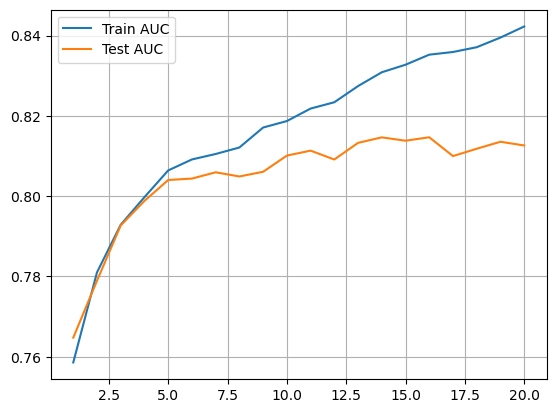

In [12]:
epochs = np.linspace(1,20, 20)
plt.plot(epochs, train_error, label = 'Train AUC')
plt.plot(epochs, test_error, label = 'Test AUC')
plt.grid(True)
plt.legend()

In [13]:
# Now let's produce the output on the test_set 
torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing)

neuralnet.eval()
with torch.no_grad():
    nn_predictions = 1 - neuralnet(torch_test.X).squeeze().numpy()  # apparently the predictions are flipped lol

# submission = pd.DataFrame({
#     'ID': test_IDs,
#     'Popularity_Type': predictions
# })
# submission.to_csv('submission.csv', index=False)

In [14]:
### Now let's train an XGboost and/or Random Forest Model

dataset = MusicDataset(training_set, is_test= False, transform=preprocessing)
X_np = dataset.X.numpy()
y_np = dataset.y.numpy()

torch_test = MusicDataset(test_set, is_test=True, transform=preprocessing)

X_test_np = torch_test.X.numpy()

max_depth_list = np.linspace(1, 25, 25, dtype = int)
auc_score_list = [0]*25
N_trials = 30 

# for _ in tqdm(range(N_trials)):
#     X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size= 0.20)

#     for max_depth in max_depth_list:
#         XGboost = XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth = max_depth)
#         XGboost.fit(X_train, y_train)
#         y_pred = XGboost.predict_proba(X_test)[:,1]

#         auc_score = roc_auc_score(y_test, y_pred)
#         auc_score_list[max_depth-1] = auc_score_list[max_depth-1] + auc_score

# np.array(auc_score_list)/N_trials

Text(0.5, 1.0, 'XGBoost Performance over different Depth')

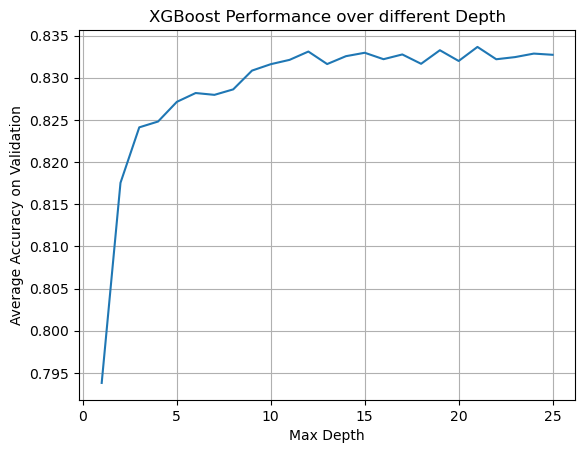

In [342]:
plt.plot(max_depth_list, np.array(auc_score_list)/N_trials)
plt.xlabel('Max Depth')
plt.ylabel('Average Accuracy on Validation')
plt.grid(True)
plt.title("XGBoost Performance over different Depth")
# On the plot below, I think we see that max_depth 17 performs really. 
# Let's try it on the Kaggle

In [436]:
# Let's go with 6, 12, and 18.

# On the plot above, I think we see that max_depth 17 performs really. 
# Let's try it on the Kaggle

max_depth_list = [6, 12, 18]
y_pred = nn_predictions * 0.8052978515625 # start from neural net's prediction
normalization_constant = 0.8052978515625 # validation accuracy of a neuralnet

for max_depth in tqdm(max_depth_list):
    XGboost= XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth= max_depth)
    XGboost.fit(X_np, y_np)
    new_pred = XGboost.predict_proba(X_test_np)[:,1]

    y_pred += new_pred * (np.array(auc_score_list)/N_trials)[max_depth-1]
    normalization_constant += (np.array(auc_score_list)/N_trials)[max_depth-1]

y_pred = y_pred/normalization_constant

100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


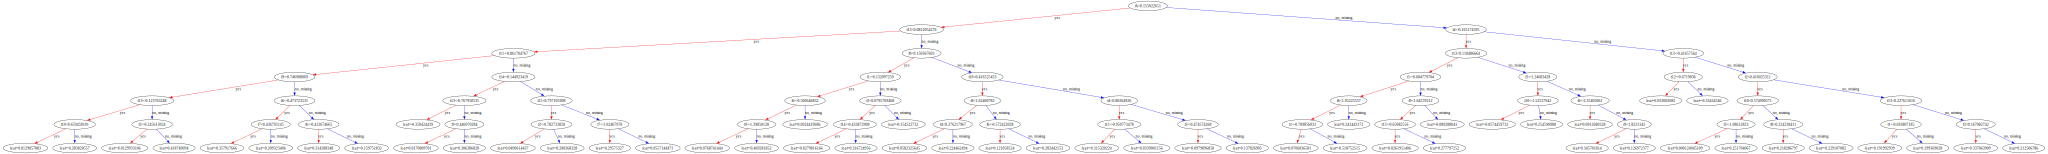

In [38]:
tree_graph = xgb.to_graphviz(XGboost, num_trees=3)
tree_graph

<Figure size 1000x2000 with 0 Axes>

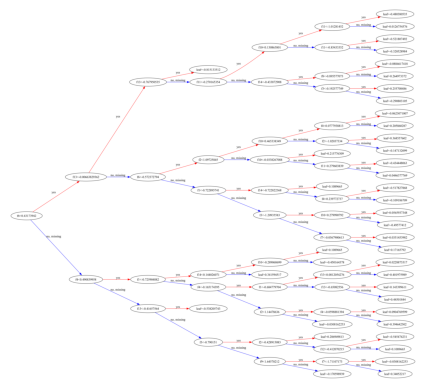

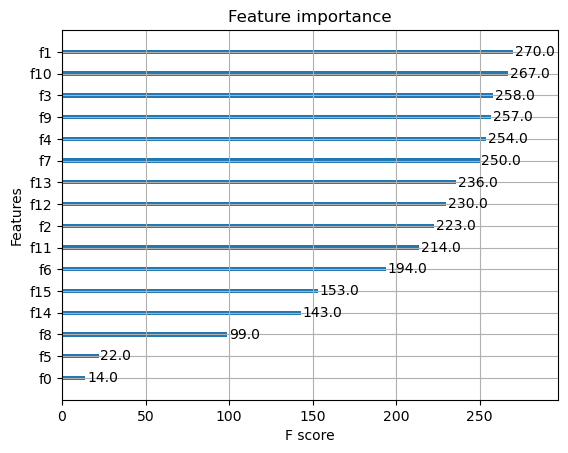

In [35]:
XGboost= XGBClassifier(objective='binary:logistic', n_estimators = 100, max_depth= 6)
XGboost.fit(X_np, y_np)
plt.figure(figsize=(10,20))
xgb.plot_tree(XGboost, num_trees=0, rankdir='LR')
xgb.plot_importance(XGboost)
plt.show()

In [411]:
# Average the prediction of a Neural Net and XGboost 
# y_final = (predictions + (1-y_pred))/2
y_final = (1-y_pred)

submission = pd.DataFrame({
    'ID': test_IDs,
    'Popularity_Type': y_final
})
submission.to_csv('submission_XGB_6_12_18_neural_net.csv', index=False)